# Visión Tarea 10
### Hacer la implementación de un kernel de derivadas utilizando imágenes integrales. La función se llamará DerivaIntegral y recibe como parámetros la imagen a derivar, el tamaño de las cajas que implementan el kernel y la dirección en la cual se aplica la derivada. El kernel estará formado por dos cajas de tamaño (2n+1)x(2n+1). Reportar:
#### Daniel Castro Pineda

In [16]:
import numpy as np
# from time import perf_counter
import cv2
import matplotlib.pyplot as plt
import numba as nb
import urllib.request

## a) La función solicitada

In [17]:
@nb.jit(nopython=True)
def integralImg(img):
    nr, nc = img.shape
    intImg = np.zeros((nr, nc), dtype=np.int32)
    intImg[0, 0] = img[0, 0]
    for r in range(1, nr):
        intImg[r, 0] = intImg[r-1, 0] + img[r, 0]
    for c in range(1, nc):
        intImg[0, c] = intImg[0, c-1] + img[0, c]
    for r in range(1, nr):
        for c in range(1, nc):
            intImg[r, c] = (intImg[r-1, c] +
                            intImg[r, c-1] -
                            intImg[r-1, c-1] +
                            img[r, c])
    return intImg


@nb.jit(nopython=True)
def caja(intImg, r, c, n, m):
    N = 2*n+1
    M = 2*m+1
    pad = (N - 1) // 2

    nrows, ncols = intImg.shape

    r0 = r - pad
    c0 = c - pad
    r1 = r + pad
    c1 = c + pad

    if r1 >= nrows:
        r1 = nrows - 1
    if c1 >= ncols:
        c1 = ncols - 1

    s0 = intImg[r1, c1]
    s1 = 0
    s2 = 0
    s3 = 0

    if r0 > 0:
        s1 = intImg[r0-1, c1]
    if c0 > 0:
        s2 = intImg[r1, c0-1]
    if r0 > 0 and c0 > 0:
        s3 = intImg[r0-1, c0-1]
    out = s0 - s1 - s2 + s3
    return out/(N)


In [18]:
@nb.jit(nopython=True)
def derivaintegral(img, tamCaja, dir):
    # intimg = np.pad(integralImg(img), tamCaja, mode='constant')
    intimg = integralImg(img)

    # caja1 = caja(tamCaja)
    # caja2 = caja(tamCaja)*-1
    nr, nc = img.shape
    out = np.zeros((nr, nc), dtype=np.float32)

    if dir == 'x':
        for r in range(nr):
            for c in range(nc):
                out[r, c] = caja(intimg, r, c+tamCaja, tamCaja, tamCaja) - \
                    caja(intimg, r, c-tamCaja, tamCaja, tamCaja)

    if dir == 'y':
        for r in range(nr):
            for c in range(nc):
                out[r, c] = caja(intimg, r+tamCaja, c, tamCaja, tamCaja) - \
                    caja(intimg, r-tamCaja, c, tamCaja, tamCaja)

    return out


In [19]:
k = np.ones((3, 3), dtype=np.float32)

# x
k = np.array([[-1, 0, 1],
             [-1, 0, 1],
             [-1, 0, 1]], dtype=np.float32) * 1/3


# k = np.array([[-1, -1, 0, 1, 1],
# [-1, -1, 0, 1, 1],
# [-1, -1, 0, 1, 1],
# [-1, -1, 0, 1, 1],
# [-1, -1, 0, 1, 1]])

# # y
# k = np.array([[1, 1, 1],
#              [0, 0, 0],
#              [-1, -1, -1]], dtype=np.float32)
# k = np.array([[1, 1, 1, 1, 1],
#               [1, 1, 1, 1, 1],
#               [0, 0, 0, 0, 0],
#               [-1, -1, -1, -1, -1],
#               [-1, -1, -1, -1, -1]], dtype=np.float32)


i = np.array([[10, 10, 20, 20, 20],
              [10, 10, 20, 20, 20],
              [10, 10, 20, 20, 20],
              [10, 10, 20, 20, 20],
              [10, 10, 20, 20, 20],
              [10, 10, 20, 20, 20],
              [10, 10, 20, 20, 20],], dtype=np.float32)


# print(integralImg(i))


In [20]:
derivaintegral(i, 1, 'x')

array([[ 20.       ,  20.       ,  13.333333 ,  -6.6666665, -26.666666 ],
       [ 30.       ,  30.       ,  20.       , -10.       , -40.       ],
       [ 30.       ,  30.       ,  20.       , -10.       , -40.       ],
       [ 30.       ,  30.       ,  20.       , -10.       , -40.       ],
       [ 30.       ,  30.       ,  20.       , -10.       , -40.       ],
       [ 30.       ,  30.       ,  20.       , -10.       , -40.       ],
       [ 20.       ,  20.       ,  13.333333 ,  -6.6666665, -26.666666 ]],
      dtype=float32)

## b) Mostrar las imágenes de la convolución con un impulso con tamaños de caja de n = 25 para derivada en X y para derivada en Y.

In [21]:
img = np.zeros((256, 256))
img[127][127] = 1

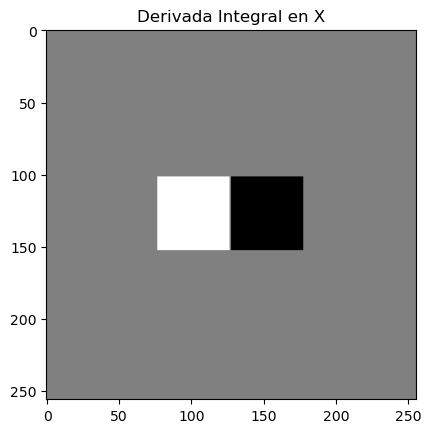

In [22]:
xDI = derivaintegral(img, 25, 'x')

plt.title('Derivada Integral en X')
plt.imshow(xDI, cmap='gray')
plt.show()

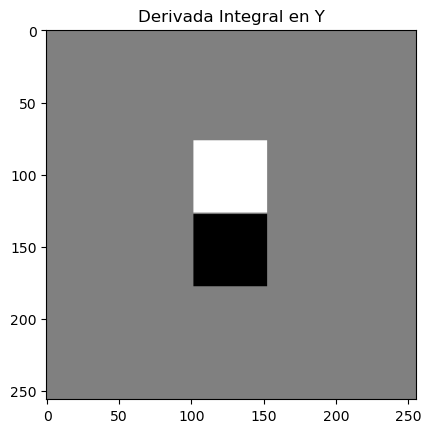

In [23]:
ydI = derivaintegral(img, 25, 'y')
plt.title('Derivada Integral en Y')
plt.imshow(ydI, cmap='gray')
plt.show()

## c) Mostrar la imagen y el valor de sigma del kernel Gausiano mas cercano para el kernel del inciso b

In [24]:

def GKernel(sigma):
  m = int(np.floor(3*sigma + 0.5))
  N = int(2*m+1)
  g = np.zeros(N)

  suma = 0
  for n in range(1, m+1):
    g[m+n] = np.exp(- n**2 / (2*sigma**2))
    suma += g[m+n]

  suma = 1 + 2*suma

  for n in range(1, m+1):
    g[m+n] /= suma
    g[m-n] = g[m+n]
  g[m] = 1/suma

  return g


def GDerivadasKernel(sigma=1, orden=0):
  """ 
  Args:
  simga int , orden 1-7
  Retorna: gausiana por n orden de derivada 
   """
  if orden >= 0 and orden < 7:
    g = GKernel(sigma)
    gz = g.size
    mu = int(np.floor(3*sigma + 0.5))
    a = np.zeros(g.size)
    if (orden == 0):
      return g
    if (orden == 1):
      return [g[x]*(mu - x)/sigma**2 for x in range(gz)]
    if (orden == 2):
      return [g[x]*(((mu-x)**2 - sigma ** 2)/sigma**4) for x in range(gz)]
    if (orden == 3):
      return [g[x]*(3*sigma**2*(x - mu) - (x - mu)**3)/sigma**6 for x in range(gz)]
    if (orden == 4):
      return [g[x]*(3*sigma**4 - 6*sigma**2*(x - mu)**2 + (x - mu)**4)/sigma**8 for x in range(gz)]
    if (orden == 5):
      return [g[x]*(10*sigma**2*(x - mu)**3 + 15*sigma**4*(mu - x) - (x - mu)**5)/sigma**10 for x in range(gz)]
    if (orden == 6):
      return [g[x]*(-15*sigma**6 - 15*sigma**2*(x - mu)**4 + 45*sigma**4*(x - mu) + (x - mu)**6)/sigma**12 for x in range(gz)]
  else:
    raise Exception("Ingresar orden 1-7")


def convolveDesacopladaDot(img, kernelx, kernely):

    if(kernelx.size != kernely.size):
      raise Exception("Kernels deben ser del mismo tamaño")

    kernelx = np.flip(kernelx)
    kernely = np.flip(kernely)

    nrows, ncols = img.shape
    k_size = kernelx.size
    # krows, kcols = kernel.shape
    pad_size = (k_size - 1) // 2
    padded_img = np.pad(img, pad_size, mode='constant')
    # print(padded_img)
    output = np.zeros((nrows, ncols))

    for i in range(nrows):
      output[i, :] = convolveDot(img[i, :], kernelx)
    # print(output)
    output2 = np.zeros((nrows, ncols))

    for j in range(ncols):
      output2[:, j] = convolveDot(output[:, j], kernely)
      # print(img[:, j])
    # print(output2)
    return output2


def convolveDot(signal, kernel):
    ker_size = kernel.size
    sig_size = signal.size
    # kernel = kernel[::-1]
    pad_size = (ker_size - 1) // 2
    padded_signal = np.pad(signal, pad_size, mode='constant')
    output = np.zeros(sig_size)
    output = [np.dot(padded_signal[k:k+ker_size], kernel)
              for k in range(sig_size)]
    # print(f"a: {output}" )
    # for k in range(sig_size):
    #     output[k] = np.dot(padded_signal[k:k+ker_size], kernel)
    # print(output)
    return output


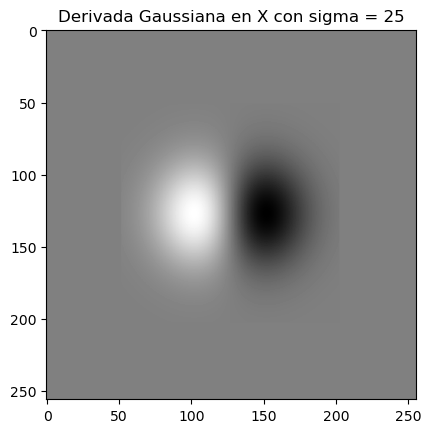

In [25]:
img = np.zeros((256, 256))
img[127][127] = 1

d0 = np.array(GDerivadasKernel(25, 0))
pd = np.array(GDerivadasKernel(25, 1))

x = convolveDesacopladaDot(img, pd, d0)
plt.title('Derivada Gaussiana en X con sigma = 25')
plt.imshow(x, cmap='gray')
plt.show()

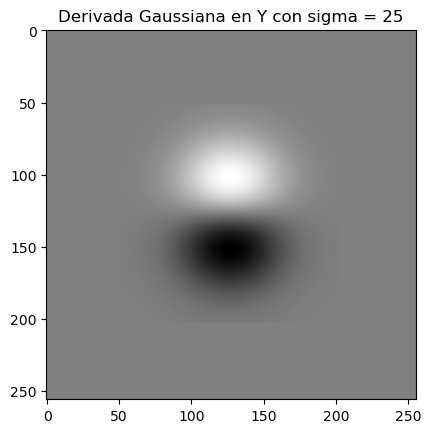

In [26]:
img = np.zeros((256, 256))
img[127][127] = 1

d0 = np.array(GDerivadasKernel(25, 0))
pd = np.array(GDerivadasKernel(25, 1))

x = convolveDesacopladaDot(img, d0, pd)

plt.title('Derivada Gaussiana en Y con sigma = 25')
plt.imshow(x, cmap='gray')
plt.show()

## d) Mostrar cuatro imágenes de la derivada dos correspondientes al kernel de caja y dos correspondiente al kernel Gausiano para derivadas en x y y respectivamente.

In [27]:
req = urllib.request.urlopen(
    'https://upload.wikimedia.org/wikipedia/commons/8/86/Bike_against_brick_wall_%28Unsplash%29.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [28]:
idix = derivaintegral(gray, 3, 'x')
idiy = derivaintegral(gray, 3, 'y')

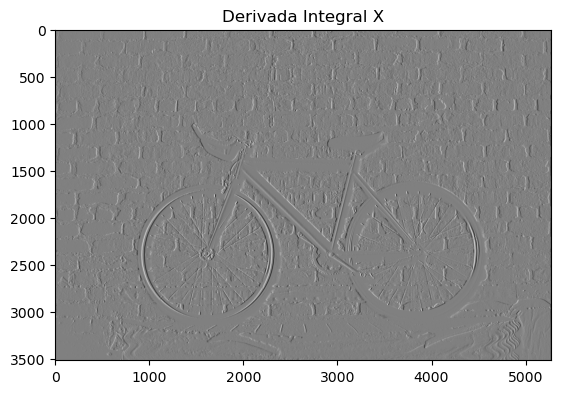

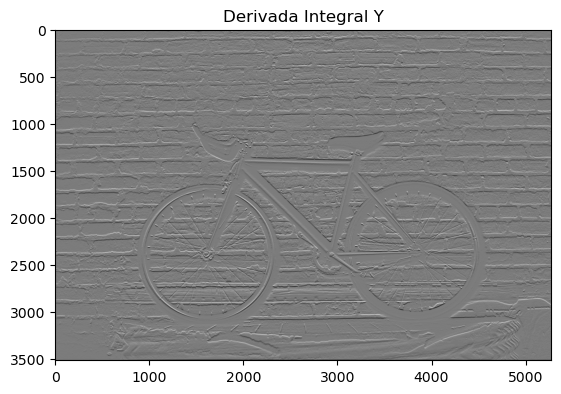

In [29]:
plt.title('Derivada Integral X')
plt.imshow(idix, cmap='gray')
plt.show()
plt.title('Derivada Integral Y')
plt.imshow(idiy, cmap='gray')
plt.show()


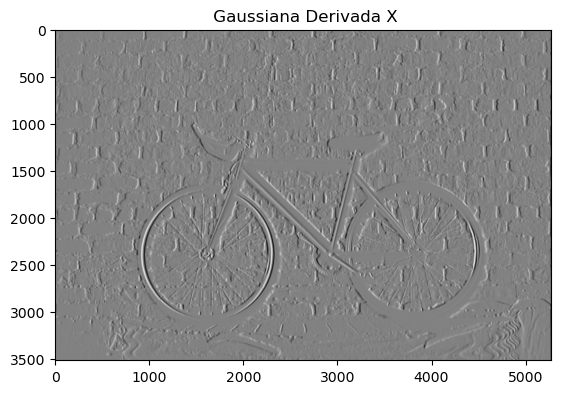

In [30]:
d0 = np.array(GDerivadasKernel(5, 0))
pd = np.array(GDerivadasKernel(5, 1))

x = convolveDesacopladaDot(gray, pd, d0)
plt.title(' Gaussiana Derivada X')
plt.imshow(x, cmap='gray')
plt.show()

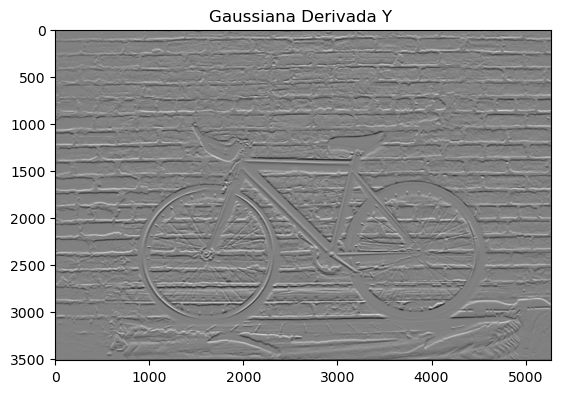

In [31]:
y = convolveDesacopladaDot(gray, d0, pd)
plt.imshow(y, cmap='gray')
plt.title('Gaussiana Derivada Y ')
plt.show()